# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

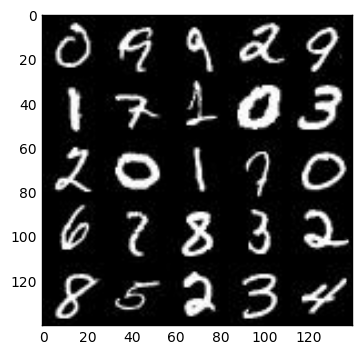

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

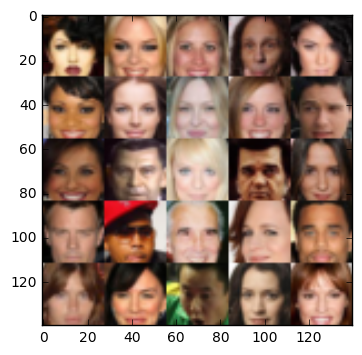

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='real_input_images')
    z_input = tf.placeholder(tf.float32,(None,z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_input_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        images = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.02))  # 14x14x64
        images = tf.maximum(alpha * images, images)
        #print(images.get_shape())
       
        images = tf.layers.conv2d(images, 128, 5, strides=2, padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.02)) # 7x7x128
        images = tf.layers.batch_normalization(images, training=True)
        images = tf.maximum(alpha * images, images)
        #print(images.get_shape())
        
        images = tf.layers.conv2d(images, 256, 3, strides=2, padding='same',
                                  kernel_initializer=tf.random_normal_initializer(stddev=0.02)) # 4x4x256
        images = tf.layers.batch_normalization(images, training=True)
        images = tf.maximum(alpha * images, images)
        #print(images.get_shape())
        
        images = tf.layers.conv2d(images, 512, 3, strides=2, padding='same',
                                 kernel_initializer=tf.random_normal_initializer(stddev=0.02)) # 2x2x512
        images = tf.layers.batch_normalization(images, training=True)
        images = tf.maximum(alpha * images, images)
        #print(images.get_shape())
        
        flat_images = tf.reshape(images, (-1, 2*2*512)) #1*4096
        #print(flat_images.get_shape())
        #flat_images = tf.layers.dropout(flat_images,rate = 0.7)
        logits = tf.layers.dense(flat_images, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha = 0.2
        z = tf.layers.dense(z, 7*7*512) 
        z = tf.reshape(z, (-1, 7, 7, 512)) # 4*4*512
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        #print(z.get_shape())
        
        z = tf.layers.conv2d_transpose(z, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02)) #14*14*256
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        #print(z.get_shape())
        
        #z = tf.layers.conv2d_transpose(z, 128, 4, strides=1, padding='valid',
        #                              kernel_initializer=tf.random_normal_initializer(stddev=0.02)) #7*7*256
        #z = tf.layers.batch_normalization(z, training=is_train)
        #z = tf.maximum(alpha * z, z)
        #print(z.get_shape())
        
        z = tf.layers.conv2d_transpose(z, 128, 5, strides=1, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02)) #14*14*128
        z = tf.layers.batch_normalization(z, training=is_train)
        #z = tf.maximum(alpha * z, z)
        
        z = tf.layers.conv2d_transpose(z, 64, 5, strides=2, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02)) #28*28*64
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        #print(z.get_shape())
        
        z = tf.layers.conv2d_transpose(z, 32, 5, strides=1, padding='same',
                                       kernel_initializer=tf.random_normal_initializer(stddev=0.02)) #28*28*32
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        #print(z.get_shape())

        logits = tf.layers.conv2d_transpose(z, out_channel_dim, 5,strides=1, padding='same',
                                           kernel_initializer=tf.random_normal_initializer(stddev=0.02)) #28x28x3/1
        #print(logits.get_shape())
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen = generator(input_z, out_channel_dim)
    dis_modelR, dis_logitsR = discriminator(input_real)
    dis_modelF, dis_logitsF = discriminator(gen, reuse=True)

    dis_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logitsR, labels=tf.ones_like(dis_modelR)))
    dis_lossF = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logitsF, labels=tf.zeros_like(dis_modelF)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logitsF, labels=tf.ones_like(dis_modelF)))
    dis_lossTot = dis_lossR + dis_lossF

    return dis_lossTot, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real,input_z,data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps=0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images*2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 10 == 0:
                    # At the end of 10 epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess,16,input_z,data_shape[3],data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 6.9114... Generator Loss: 0.0013
Epoch 1/2... Discriminator Loss: 2.1766... Generator Loss: 0.2909
Epoch 1/2... Discriminator Loss: 2.0171... Generator Loss: 0.2463
Epoch 1/2... Discriminator Loss: 1.8162... Generator Loss: 0.2633
Epoch 1/2... Discriminator Loss: 1.7425... Generator Loss: 0.3977
Epoch 1/2... Discriminator Loss: 1.4184... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.9350
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.7535
Epoch 1/2... Discriminator Loss: 1.3843... Generator Loss: 0.4293


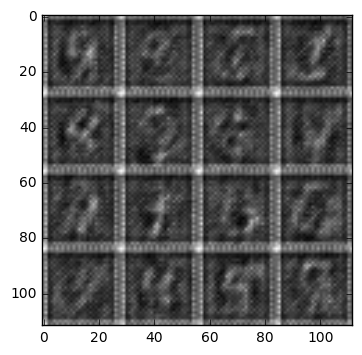

Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.1797... Generator Loss: 0.6260
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 1.0331
Epoch 1/2... Discriminator Loss: 1.5561... Generator Loss: 0.3313
Epoch 1/2... Discriminator Loss: 1.6734... Generator Loss: 0.2615
Epoch 1/2... Discriminator Loss: 1.1251... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 0.6609
Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.3137
Epoch 1/2... Discriminator Loss: 1.3353... Generator Loss: 0.7419
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.4640


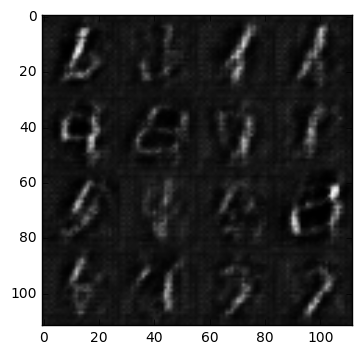

Epoch 1/2... Discriminator Loss: 1.3001... Generator Loss: 1.9822
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 1.1915
Epoch 1/2... Discriminator Loss: 1.1646... Generator Loss: 1.0255
Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.8610
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 1.0912
Epoch 1/2... Discriminator Loss: 1.1411... Generator Loss: 0.9528
Epoch 1/2... Discriminator Loss: 1.1885... Generator Loss: 0.5714


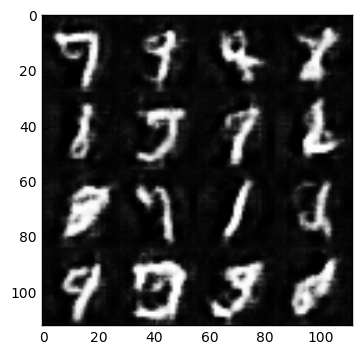

Epoch 1/2... Discriminator Loss: 3.3770... Generator Loss: 0.0435
Epoch 1/2... Discriminator Loss: 1.2071... Generator Loss: 0.5548
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.7393
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.5696
Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 1.6174
Epoch 1/2... Discriminator Loss: 1.0314... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 2.2242... Generator Loss: 2.6046
Epoch 1/2... Discriminator Loss: 1.0883... Generator Loss: 0.7294
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 0.8420
Epoch 1/2... Discriminator Loss: 0.9982... Generator Loss: 0.7707


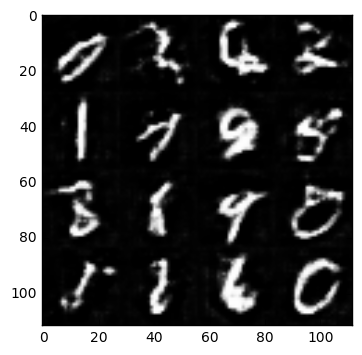

Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.6316... Generator Loss: 0.3013
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.3958
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 0.8093
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 1.7828
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.6622
Epoch 1/2... Discriminator Loss: 2.0425... Generator Loss: 1.6590
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 0.7849


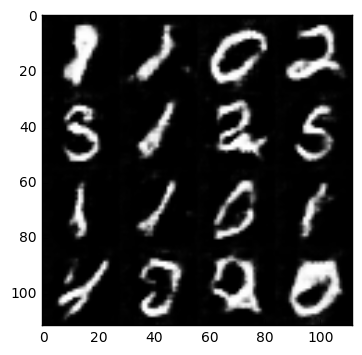

Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 1.4469
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 0.8453
Epoch 1/2... Discriminator Loss: 1.6685... Generator Loss: 0.2695
Epoch 1/2... Discriminator Loss: 0.8333... Generator Loss: 0.9829
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 0.5329
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.6184
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.4765
Epoch 1/2... Discriminator Loss: 2.8625... Generator Loss: 0.0891
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.5759


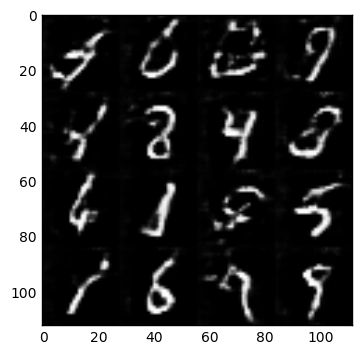

Epoch 1/2... Discriminator Loss: 1.3395... Generator Loss: 0.4249
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.5075
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 1.0272
Epoch 1/2... Discriminator Loss: 1.1710... Generator Loss: 1.1988
Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 0.3037
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 1.1538
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 1.0235
Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 0.4324
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 1.0526... Generator Loss: 0.6655


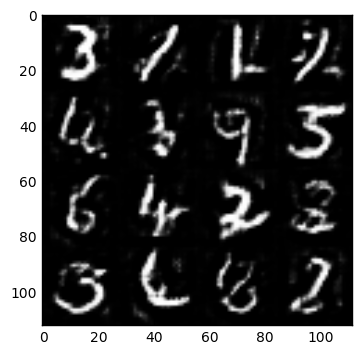

Epoch 1/2... Discriminator Loss: 0.8039... Generator Loss: 0.8576
Epoch 1/2... Discriminator Loss: 0.9662... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.9716... Generator Loss: 0.1870
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.5768
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.6495
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.6008
Epoch 1/2... Discriminator Loss: 1.0722... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 1.4195... Generator Loss: 0.8137
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 0.8763
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 0.8827


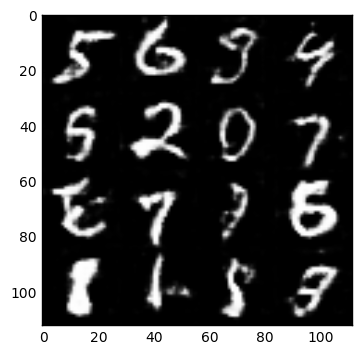

Epoch 1/2... Discriminator Loss: 1.1003... Generator Loss: 1.0938
Epoch 1/2... Discriminator Loss: 0.7861... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.7113
Epoch 1/2... Discriminator Loss: 1.7149... Generator Loss: 0.2874
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 0.5934
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.4705
Epoch 1/2... Discriminator Loss: 1.2874... Generator Loss: 0.4518
Epoch 1/2... Discriminator Loss: 1.3645... Generator Loss: 0.4202
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 0.7328
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.5383


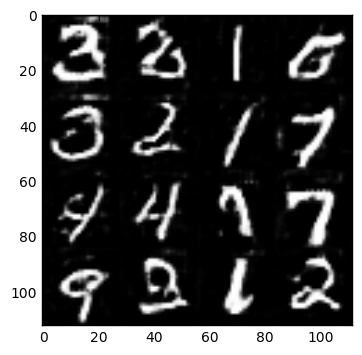

Epoch 1/2... Discriminator Loss: 1.4927... Generator Loss: 0.3377
Epoch 1/2... Discriminator Loss: 0.8029... Generator Loss: 1.5362
Epoch 1/2... Discriminator Loss: 1.0914... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.6931... Generator Loss: 0.2625
Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 0.9082
Epoch 2/2... Discriminator Loss: 1.8398... Generator Loss: 0.2116
Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.4405
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.3924
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.6515
Epoch 2/2... Discriminator Loss: 0.4970... Generator Loss: 1.6404
Epoch 2/2... Discriminator Loss: 1.9054... Generator Loss: 0.2188


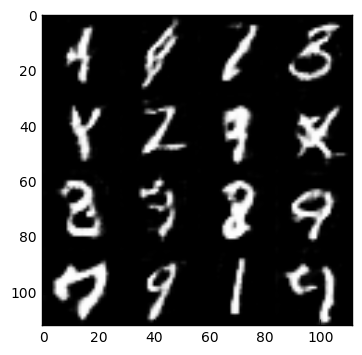

Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 1.0437
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.4338
Epoch 2/2... Discriminator Loss: 0.9661... Generator Loss: 0.7513
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 0.8162... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 0.9223... Generator Loss: 0.7171
Epoch 2/2... Discriminator Loss: 1.5390... Generator Loss: 0.3252
Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 0.7914
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.0812


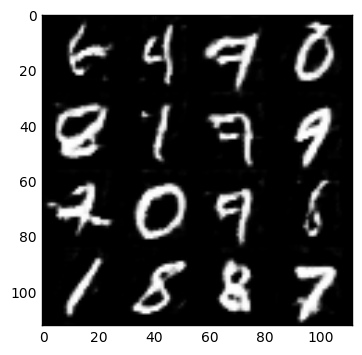

Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 1.2535
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 0.7492
Epoch 2/2... Discriminator Loss: 1.3314... Generator Loss: 0.3911
Epoch 2/2... Discriminator Loss: 1.8577... Generator Loss: 0.2550
Epoch 2/2... Discriminator Loss: 1.3313... Generator Loss: 0.4325
Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 0.6256
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.2888
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.1757
Epoch 2/2... Discriminator Loss: 1.5654... Generator Loss: 0.2942


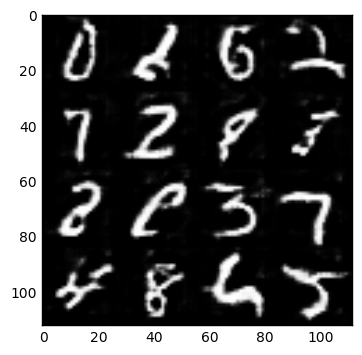

Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.3627
Epoch 2/2... Discriminator Loss: 0.8630... Generator Loss: 1.8765
Epoch 2/2... Discriminator Loss: 1.1210... Generator Loss: 0.5049
Epoch 2/2... Discriminator Loss: 0.8752... Generator Loss: 1.3634
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 0.4830
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 0.9014... Generator Loss: 1.3323
Epoch 2/2... Discriminator Loss: 0.8482... Generator Loss: 0.8781
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.5443


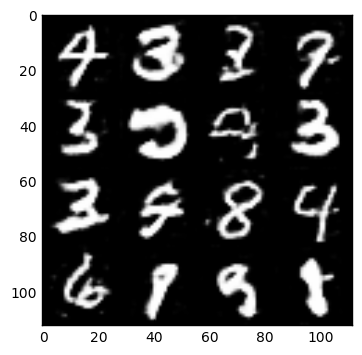

Epoch 2/2... Discriminator Loss: 1.1110... Generator Loss: 0.5078
Epoch 2/2... Discriminator Loss: 1.8287... Generator Loss: 0.2090
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 1.5389
Epoch 2/2... Discriminator Loss: 1.6454... Generator Loss: 0.2934
Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 1.6793
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.1675
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.5393
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 0.6357
Epoch 2/2... Discriminator Loss: 0.7134... Generator Loss: 1.3068
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.5210


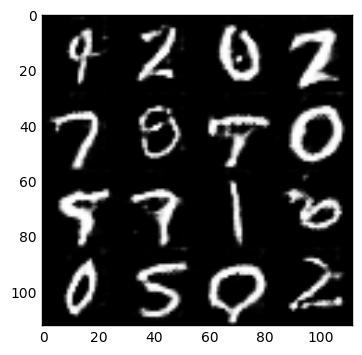

Epoch 2/2... Discriminator Loss: 0.8109... Generator Loss: 0.8981
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 1.4724
Epoch 2/2... Discriminator Loss: 0.8165... Generator Loss: 1.2567
Epoch 2/2... Discriminator Loss: 0.8690... Generator Loss: 0.6594
Epoch 2/2... Discriminator Loss: 1.2264... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.0376... Generator Loss: 0.9131
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.5917
Epoch 2/2... Discriminator Loss: 1.1087... Generator Loss: 0.5267
Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 0.3869


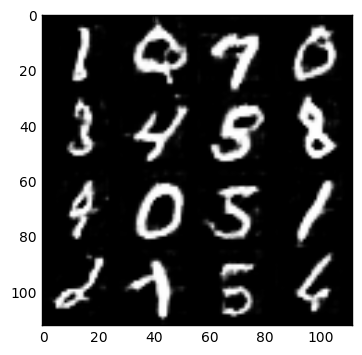

Epoch 2/2... Discriminator Loss: 1.0321... Generator Loss: 0.6118
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 0.8985
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 1.2378
Epoch 2/2... Discriminator Loss: 1.2695... Generator Loss: 0.4851
Epoch 2/2... Discriminator Loss: 0.7872... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 0.8559... Generator Loss: 0.9636
Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 0.8014
Epoch 2/2... Discriminator Loss: 1.7860... Generator Loss: 2.3698


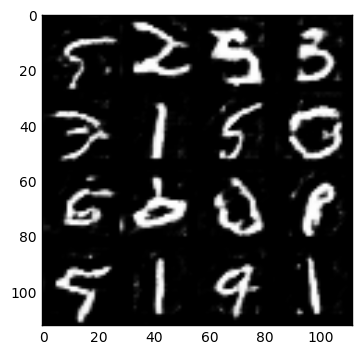

Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.5174
Epoch 2/2... Discriminator Loss: 1.5963... Generator Loss: 0.3582
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.5873
Epoch 2/2... Discriminator Loss: 0.8699... Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 1.1286... Generator Loss: 0.4967
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.4133
Epoch 2/2... Discriminator Loss: 1.2820... Generator Loss: 0.6989
Epoch 2/2... Discriminator Loss: 1.6774... Generator Loss: 1.6657
Epoch 2/2... Discriminator Loss: 0.7186... Generator Loss: 0.9718


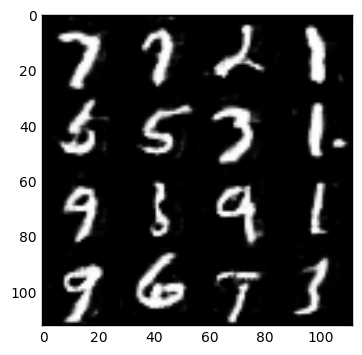

Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 0.6178
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.2109
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 0.6373
Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.4402
Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.1764
Epoch 2/2... Discriminator Loss: 1.7441... Generator Loss: 0.2801
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.4084
Epoch 2/2... Discriminator Loss: 1.3347... Generator Loss: 0.3744
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.3925
Epoch 2/2... Discriminator Loss: 1.6590... Generator Loss: 0.2804


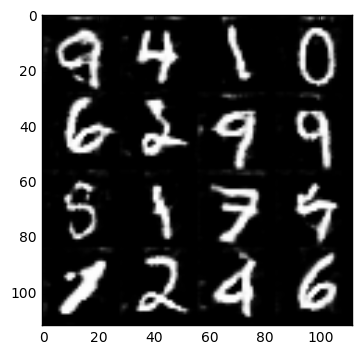

Epoch 2/2... Discriminator Loss: 1.4299... Generator Loss: 0.3694
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.3388
Epoch 2/2... Discriminator Loss: 1.1866... Generator Loss: 0.5973


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9934... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 2.6535
Epoch 1/1... Discriminator Loss: 1.8192... Generator Loss: 0.3398
Epoch 1/1... Discriminator Loss: 1.8466... Generator Loss: 0.4534
Epoch 1/1... Discriminator Loss: 0.8853... Generator Loss: 1.4602
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.5923... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 1.1458


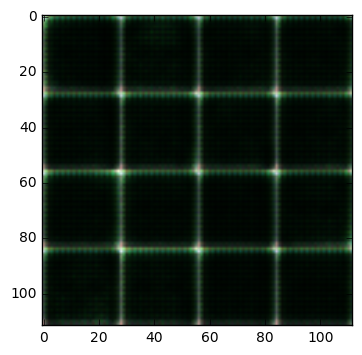

Epoch 1/1... Discriminator Loss: 1.6766... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 1.1889
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.4543
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.7603... Generator Loss: 0.3512
Epoch 1/1... Discriminator Loss: 2.1479... Generator Loss: 0.1788
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.5923
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.3969
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.4629


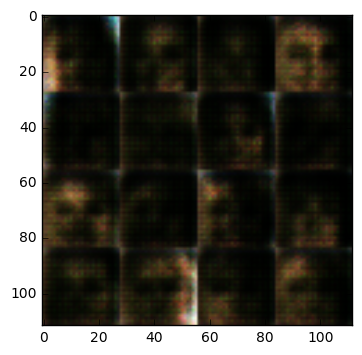

Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 1.2794
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.7555
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.6098... Generator Loss: 1.3832


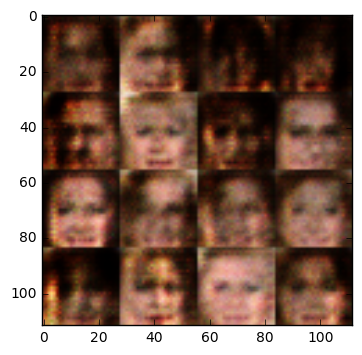

Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.6463... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.6465


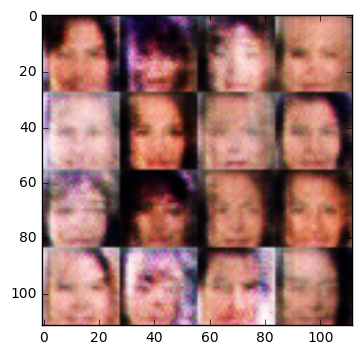

Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.2527... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7224
Epoch 1/1... Discriminator Loss: 1.5897... Generator Loss: 0.4898


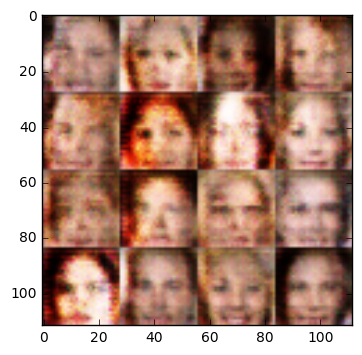

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.7718


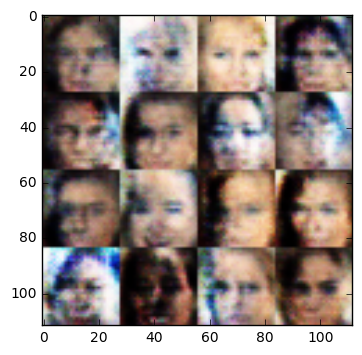

Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.5904
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7987


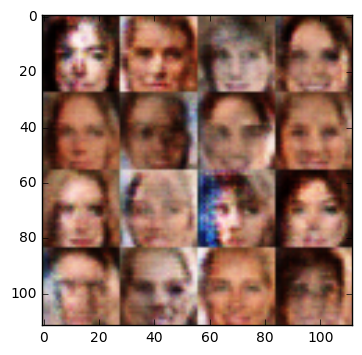

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.2016... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.8900
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8174


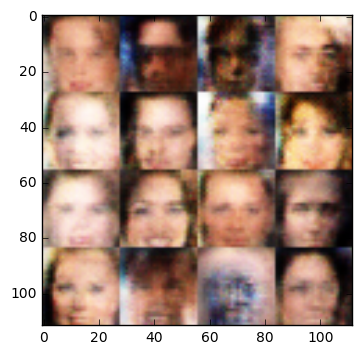

Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6076
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.5929


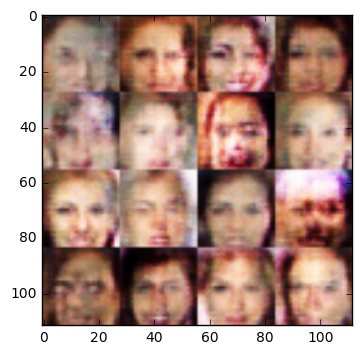

Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.5992
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8574
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9075


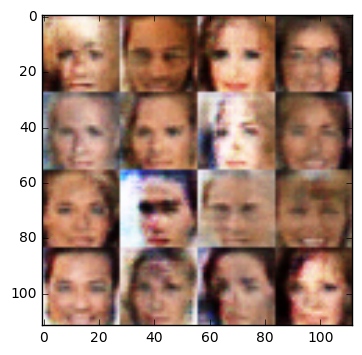

Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.1814... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7302


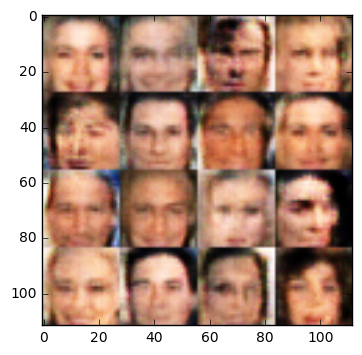

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.5035... Generator Loss: 0.5186
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.6818


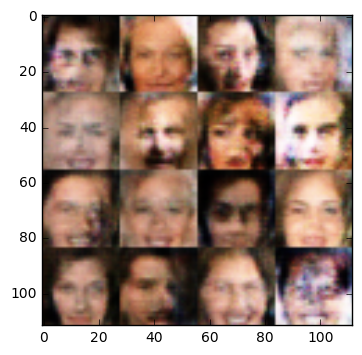

Epoch 1/1... Discriminator Loss: 1.2792... Generator Loss: 0.5823
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.5790


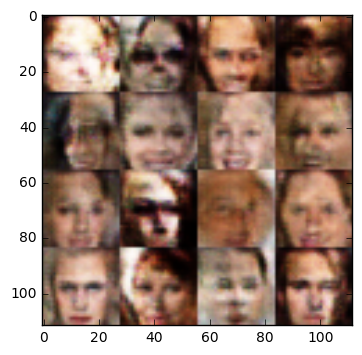

Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.5498
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5643


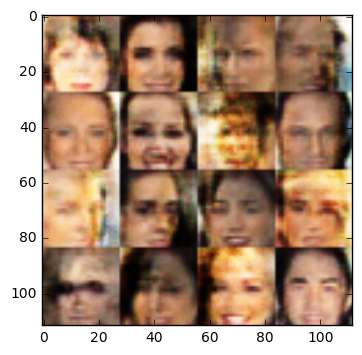

Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8736


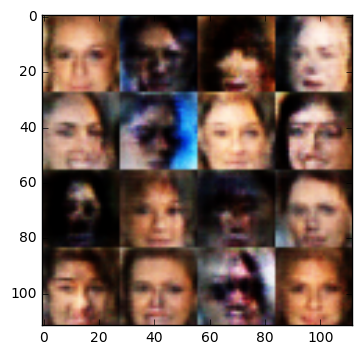

Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.5517
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.6660


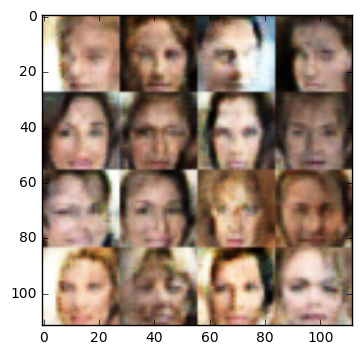

Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.5766


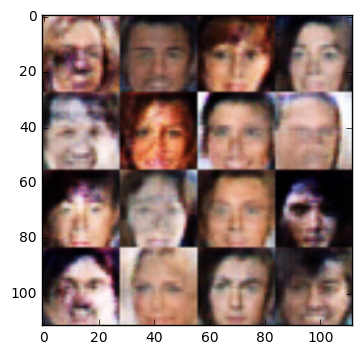

Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.5149
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.6051


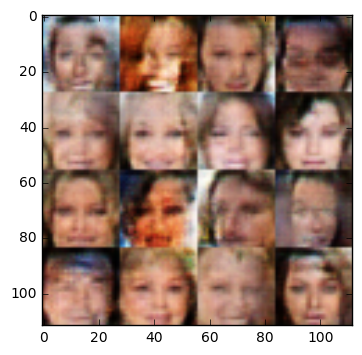

Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.3876... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.8549
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7636


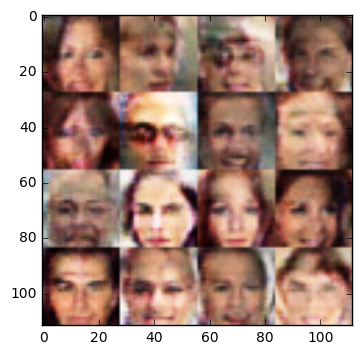

Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.4633
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.2869... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.5934


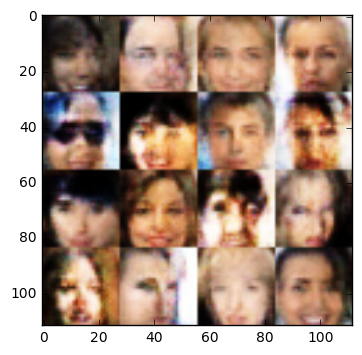

Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.1733... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6651
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.6039
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.5755


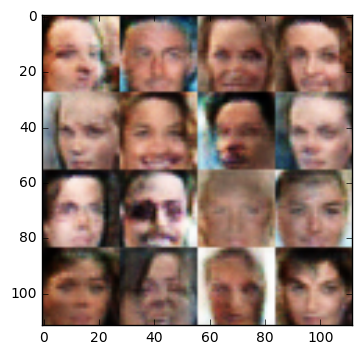

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3396... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.5326
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.4778


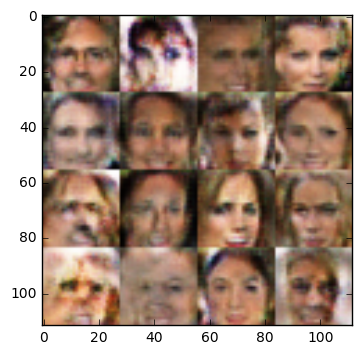

Epoch 1/1... Discriminator Loss: 1.4339... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.5379
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.4940
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.6756


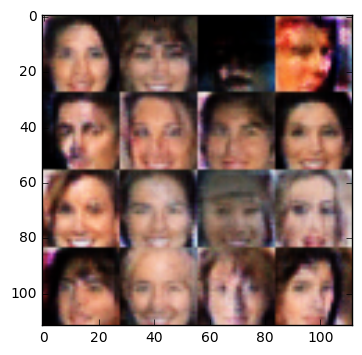

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.4915... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.5760


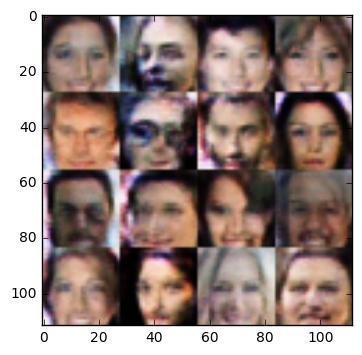

Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.2641... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.6819


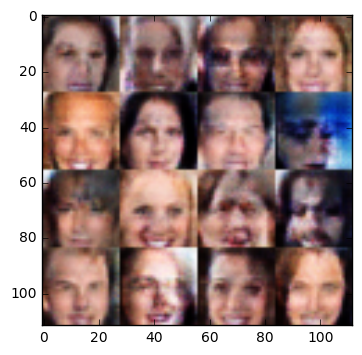

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8255
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.7792


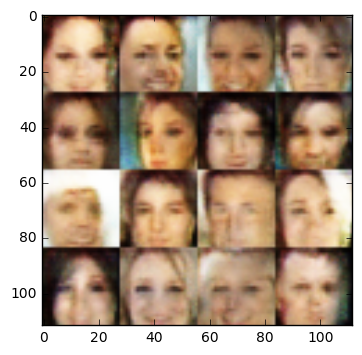

Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.5440


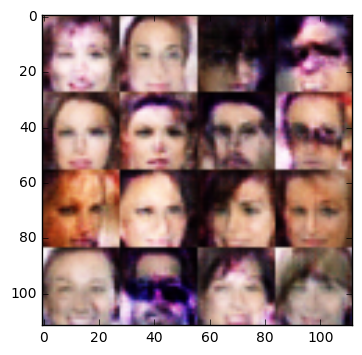

Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.5869
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.2104... Generator Loss: 0.8308
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.7572


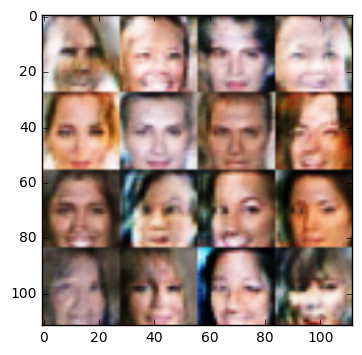

Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.0161... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.6922


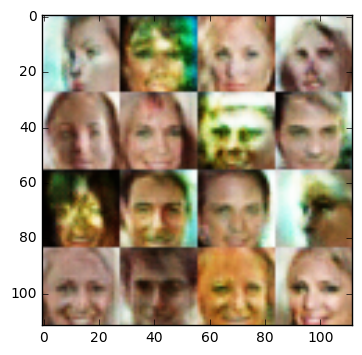

Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.7469


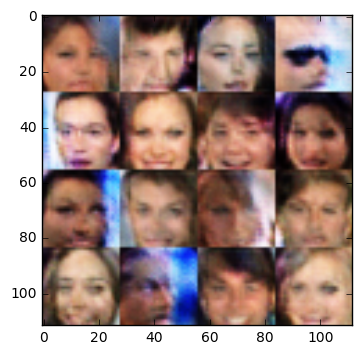

Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.6355
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5752
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.5965


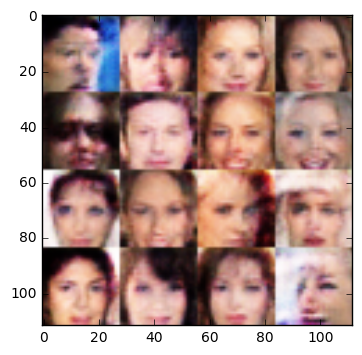

Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5773
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.0226


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.